In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Import essential models and functions from sklearn
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sb.set() # set the default Seaborn style for graphics

from pywaffle import Waffle #waffle chart


import warnings 
warnings.filterwarnings('ignore') # remove error like FutureWarning about function being deprecated 

# Data preparation and cleaning

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
round (data.describe(exclude = 'object'), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


In [4]:
round (data.describe(exclude = ['int64', 'float']), 2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


Turn all the 0 and 1 categorical variables into booleans:

In [5]:
data["stroke"] = data["stroke"].astype(bool)
data["hypertension"] = data["hypertension"].astype(bool)
data["heart_disease"] = data["heart_disease"].astype(bool)

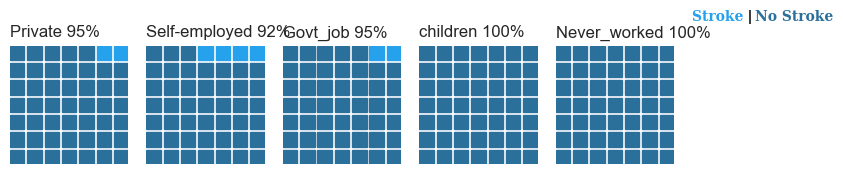

In [6]:
def waffleplot(param, y_coord, listValue = None):
    '''
    Issue on fontsawesome icon for window on the latest version of matplotlib
        https://github.com/gyli/PyWaffle/issues/33
    '''
    
    waffleDf= data.copy()

    if listValue is not None:
        waffleDf = waffleDf[waffleDf[param].isin(listValue)]
    
    uniqueList = waffleDf[param].unique()
    paramObj = {}
    index = 0
    id = 100 +  len(uniqueList)*10

    
    for uniqueParam in uniqueList:
        paramName = uniqueParam
        
        index += 1
        id += 1
        stroke_param = waffleDf[(waffleDf['stroke'] == 1)&(waffleDf[param]==uniqueParam)][param].value_counts()
        healthy_param= waffleDf[(waffleDf['stroke'] == 0)&(waffleDf[param]==uniqueParam)][param].value_counts()
        param_value = waffleDf[waffleDf[param]==uniqueParam][param].value_counts().values[0]

        if (stroke_param.empty):
            stroke_value = 0
        else:
            stroke_value = int(round (stroke_param.values[0] / param_value * 100, 0))
            
        if (healthy_param.empty):
            healthy_param = 0
        else:
            healthy_value = int(round(healthy_param.values[0] / param_value * 100, 0))

        per = int(round(healthy_value/(healthy_value+stroke_value) * 100, 0))

        paramObj[id]= {}
        paramObj[id]['values']=[stroke_value, healthy_value]
        paramObj[id]['title']={'label': f'{paramName} {(per)}%', 'loc': 'left', 'fontsize': 12}
        paramObj[id]['starting_location']='NE'
        paramObj[id]['vertical']=True
        paramObj[id]['rows']=7
        paramObj[id]['columns']=7

        
    fig = plt.figure(
        FigureClass = Waffle,
        colors = ['#26A1EB','#2B709A'],
        plots = paramObj,
        figsize = (7,7),    
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    )

    
    fig.text(1,0.62, 'Stroke ', {'font': 'Serif','weight':'bold','fontsize': '10','weight':'bold','style':'normal', 'color':'#26A1EB'})
    fig.text(1.08,0.62, '|', {'color':'black' , 'fontsize':'10', 'weight': 'bold'})
    fig.text(1.09,0.62, 'No Stroke', {'font': 'Serif','weight':'bold', 'fontsize': '10','style':'normal', 'weight':'bold','color':'#2B709A'},alpha = 1)
    plt.show()
        
waffleplot('work_type', 0.70)



## Hypertension

In [7]:
data["hypertension"].value_counts()

hypertension
False    4612
True      498
Name: count, dtype: int64

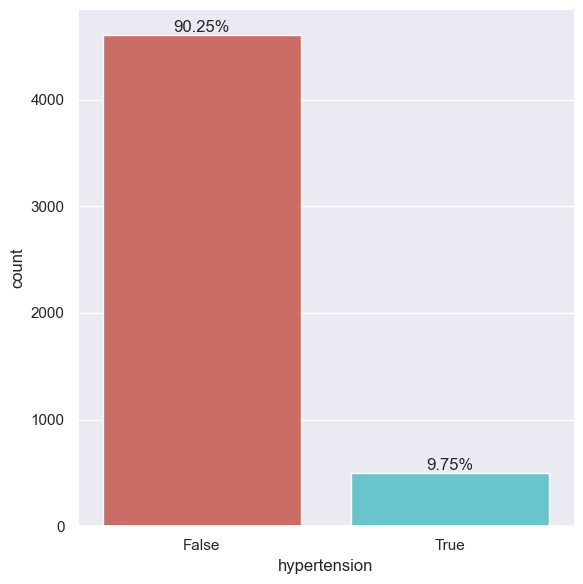

In [8]:
f = sb.catplot(x = "hypertension", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "hypertension")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

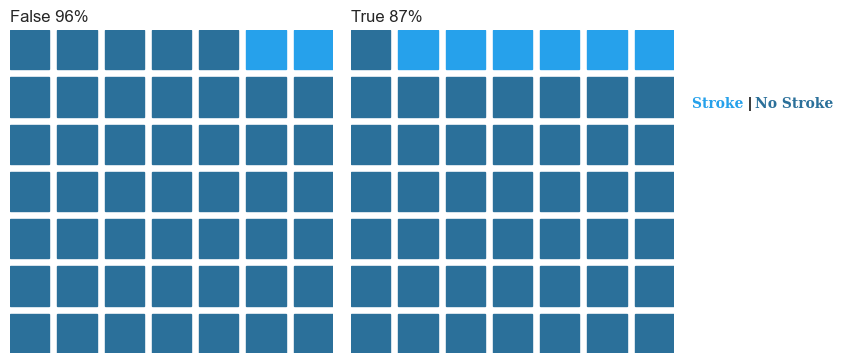

In [9]:
waffleplot('hypertension', 0.78)

## Heart disease

In [10]:
data["heart_disease"].value_counts()

heart_disease
False    4834
True      276
Name: count, dtype: int64

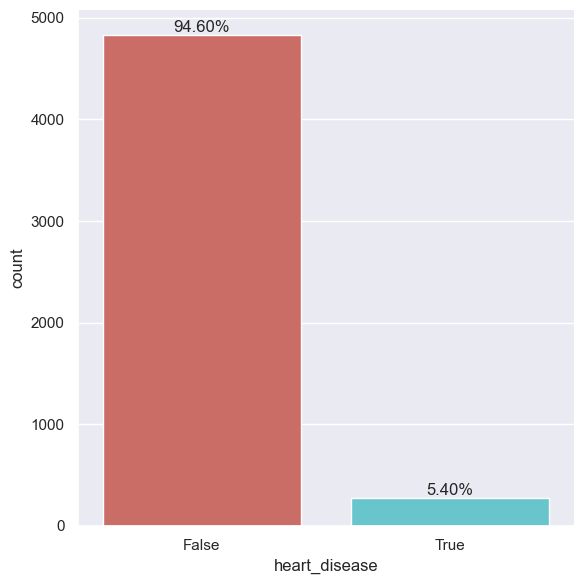

In [11]:
f = sb.catplot(x = "heart_disease", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "heart_disease")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

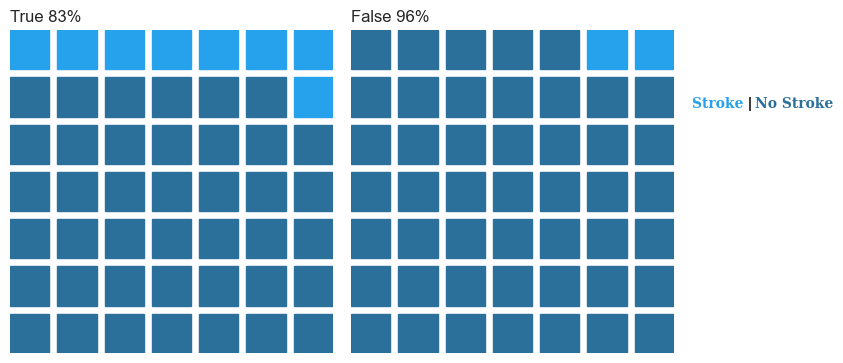

In [12]:
waffleplot('heart_disease', 0.78)

## Gender

In [13]:
data[["gender"]].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

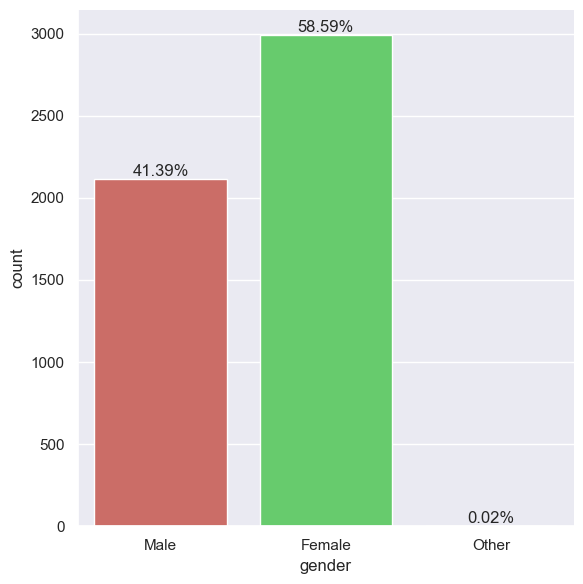

In [14]:
f = sb.catplot(x = "gender", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "gender")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [15]:
gender = pd.DataFrame(data[["gender"]])

for i in gender:
    others = gender[(gender[i] == "Other")]
    gender_data = gender.drop(others.index)

label = LabelEncoder()
gender_data["gender"] = label.fit_transform(gender_data["gender"].astype("str"))

gender_data.value_counts()

gender
0         2994
1         2115
Name: count, dtype: int64

<span style="color:red"> Note that 0: Female, 1: Male </span>

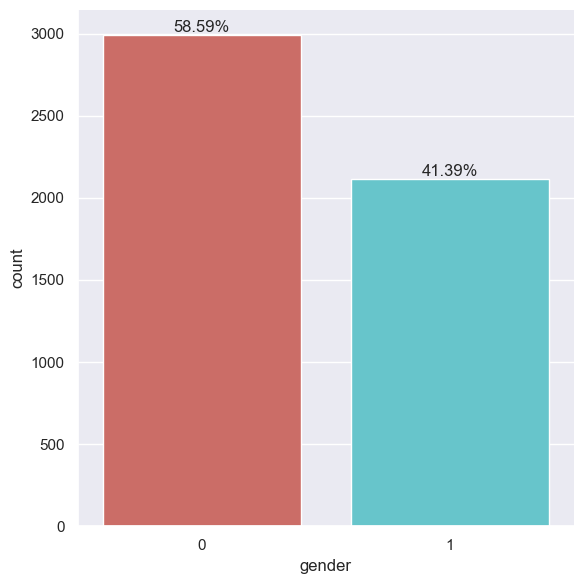

In [16]:
f = sb.catplot(x = "gender", data = gender_data, kind = "count", height=6, palette="hls", legend=False, hue = "gender")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

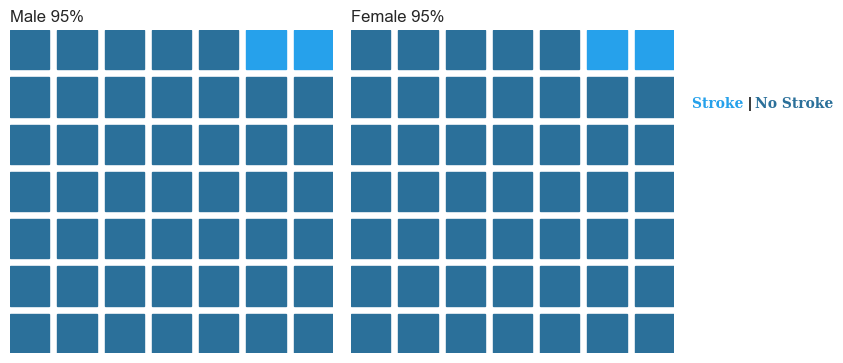

In [17]:
waffleplot('gender', 0.78,['Male', 'Female'])

## Residence type

In [18]:
data[["Residence_type"]].value_counts()

Residence_type
Urban             2596
Rural             2514
Name: count, dtype: int64

In [19]:
residence_data = pd.DataFrame(data[["Residence_type"]])

residence_data["Residence_type"] = label.fit_transform(residence_data["Residence_type"].astype("str"))

residence_data.value_counts()

Residence_type
1                 2596
0                 2514
Name: count, dtype: int64

<span style="color:red"> Note: 0: Rural, 1: Urban </span>

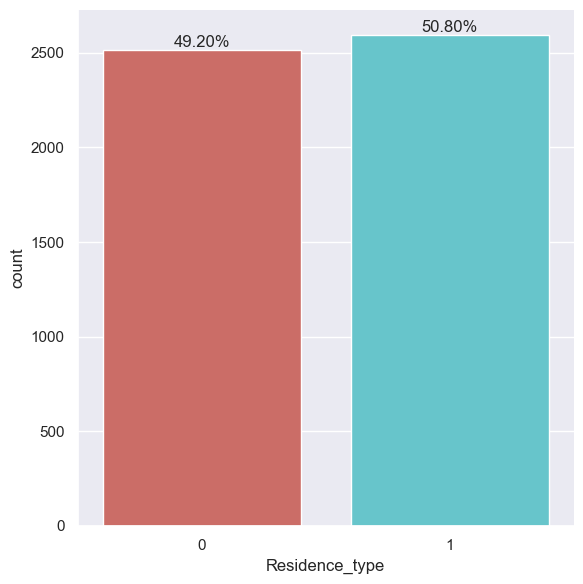

In [20]:
f = sb.catplot(x = "Residence_type", data = residence_data, kind = "count", height=6, palette="hls", legend=False, hue = "Residence_type")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

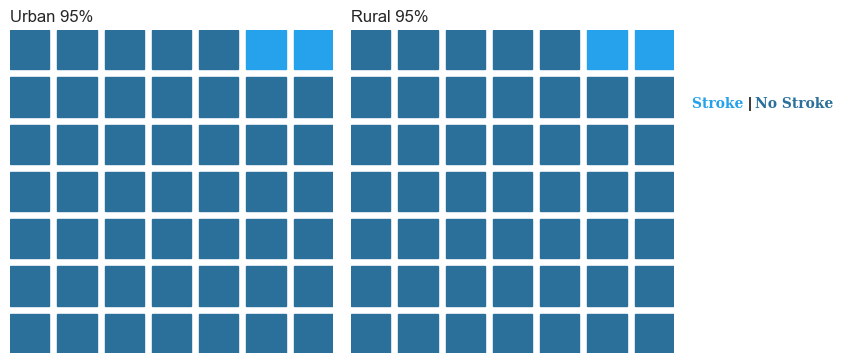

In [21]:
waffleplot('Residence_type', 0.78)

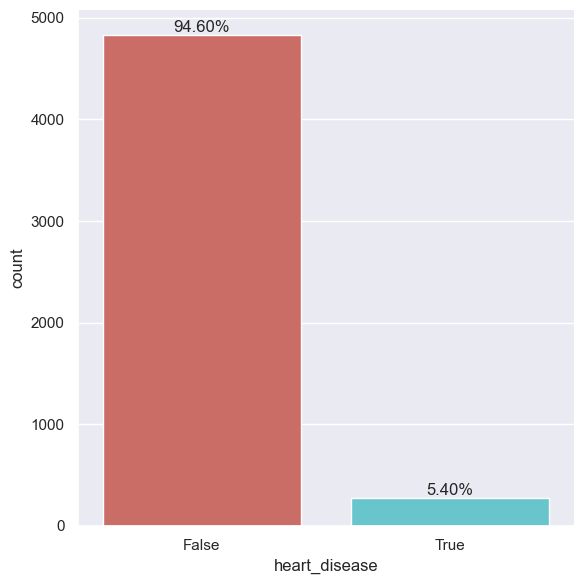

In [22]:
f = sb.catplot(x = "heart_disease", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "heart_disease")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

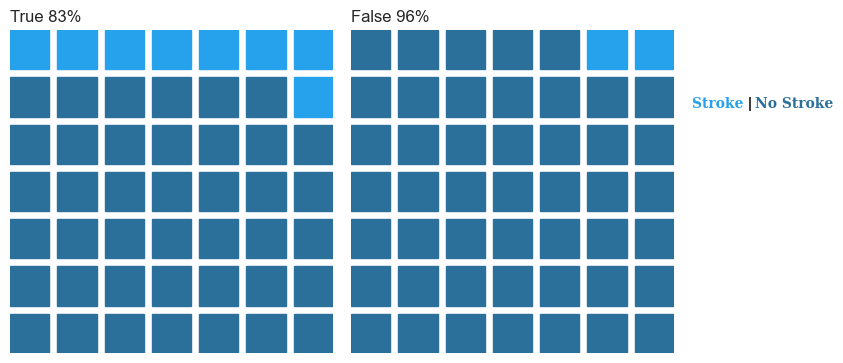

In [23]:
waffleplot('heart_disease', 0.78)

## Ever married

In [24]:
data[["ever_married"]].value_counts()

ever_married
Yes             3353
No              1757
Name: count, dtype: int64

In [47]:
ever_data = pd.DataFrame(data[["ever_married"]])

label = LabelEncoder()
ever_data["ever_married"] = label.fit_transform(ever_data["ever_married"].astype("str"))
ever_data.value_counts()

ever_married
1               3353
0               1757
Name: count, dtype: int64

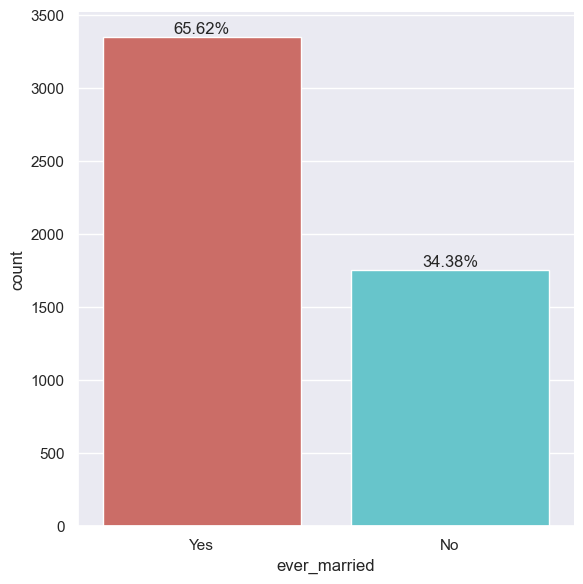

In [48]:
f = sb.catplot(x = "ever_married", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "ever_married")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

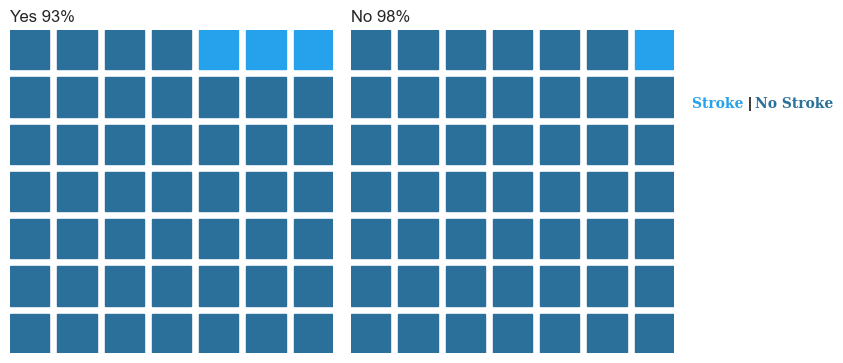

In [49]:
waffleplot('ever_married', 0.78)

## Smoking status

In [27]:
data["smoking_status"].describe()

count             5110
unique               4
top       never smoked
freq              1892
Name: smoking_status, dtype: object

In [28]:
smoking = pd.DataFrame(data[["smoking_status"]])

for i in smoking:
    unknowns = smoking[(smoking[i] == "Unknown")]
    smoking_data = smoking.drop(unknowns.index)

smoking_data.value_counts()

smoking_status 
never smoked       1892
formerly smoked     885
smokes              789
Name: count, dtype: int64

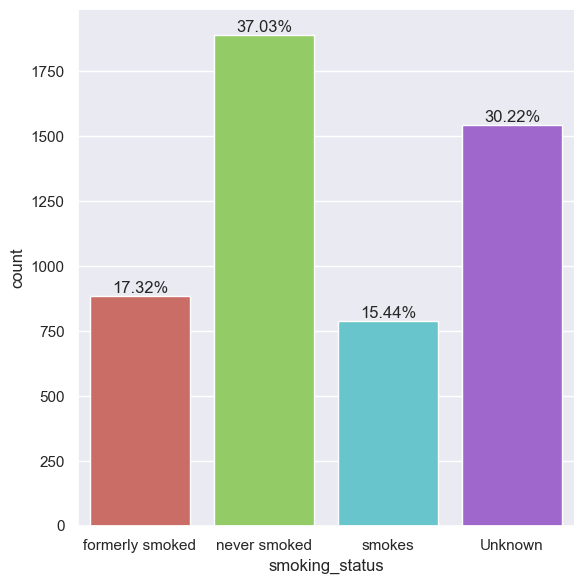

In [29]:
f = sb.catplot(x = "smoking_status", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "smoking_status")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

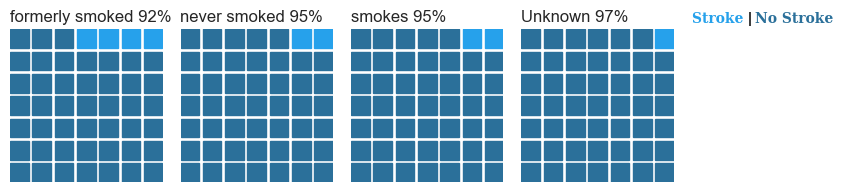

In [30]:
waffleplot('smoking_status', 0.70)

In [31]:
sdata = smoking_data.replace('never smoked', 0)
clean_smoking_data = sdata.replace(['formerly smoked', 'smokes'], 1)

clean_smoking_data.value_counts()

smoking_status
0                 1892
1                 1674
Name: count, dtype: int64

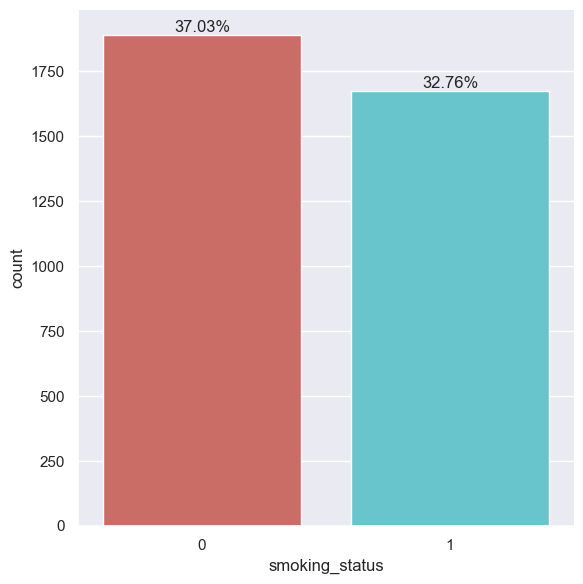

In [32]:
f = sb.catplot(x = "smoking_status", data = clean_smoking_data, kind = "count", height=6, palette="hls", legend=False, hue = "smoking_status")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [33]:
data["smoking"] = data['smoking_status']
data["smoking"] = data["smoking"].replace(['Unknown'], -1)
data["smoking"] = data["smoking"].replace(['formerly smoked', 'smokes'], 1)
data["smoking"] = data["smoking"].replace(['never smoked'], 0)
data["smoking"] = data["smoking"].astype('int')
data["smoking"] = data["smoking"].replace([-1], None)

data["smoking"].value_counts()

smoking
0    1892
1    1674
Name: count, dtype: int64

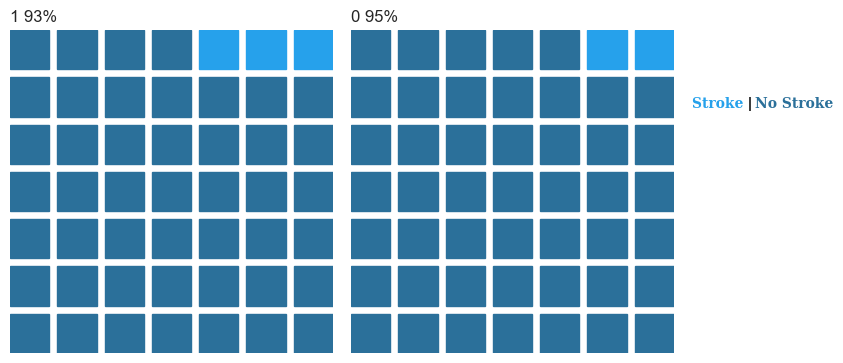

In [34]:
waffleplot('smoking', 0.70, [1,0])

## Work type

In [35]:
data[["work_type"]].value_counts()

work_type    
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [51]:
work_data = pd.DataFrame(data[["work_type"]])

label = LabelEncoder()
work_data["work_type"] = label.fit_transform(work_data["work_type"].astype("str"))
work_data.value_counts()

work_type
2            2925
3             819
4             687
0             657
1              22
Name: count, dtype: int64

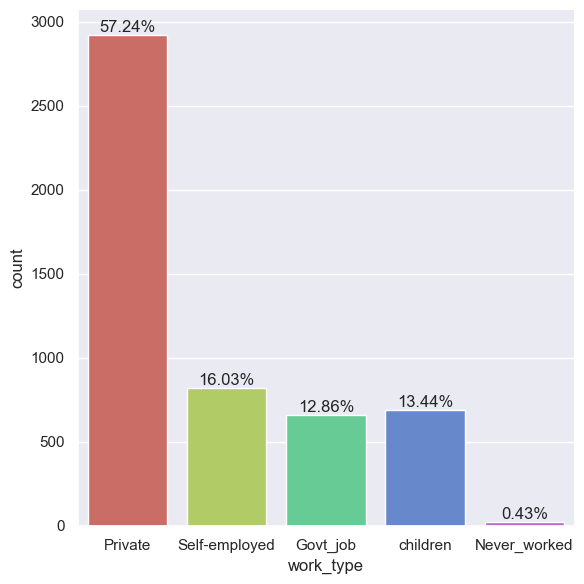

In [52]:
f = sb.catplot(x = "work_type", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "work_type")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

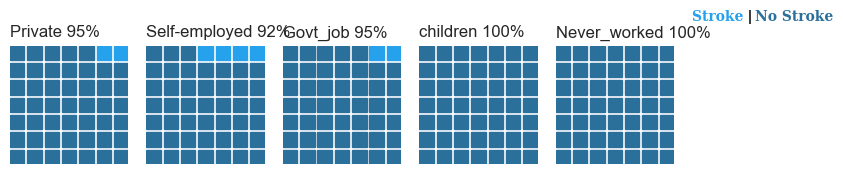

In [53]:
waffleplot('work_type', 0.70)

## Numerical data cleaning (Glucose, BMI, Age)

In [38]:
def RemoveOutliers(data):
    for i in data:
        q1 = data[i].describe(include='all').loc['25%']
        q3 = data[i].describe(include='all').loc['75%']
        IQR = q3 - q1
        btmThresh = q1 - 1.5 * IQR
        topThresh = q3 + 1.5 * IQR
        outliers = data[(data[i] < btmThresh) | (data[i] > topThresh)]
        print('Removed', len(outliers), 'outliers from', i)
        cleandata = data.drop(outliers.index)
        return cleandata

In [39]:
glucose = pd.DataFrame(data[["avg_glucose_level"]])
bmi = pd.DataFrame(data[["bmi"]])
age_data = pd.DataFrame(data[["age"]])

bmi.dropna()

data[["avg_glucose_level"]] = RemoveOutliers(data[["avg_glucose_level"]])
data[["bmi"]] = RemoveOutliers(data[["bmi"]])

Removed 627 outliers from avg_glucose_level
Removed 110 outliers from bmi


<Axes: >

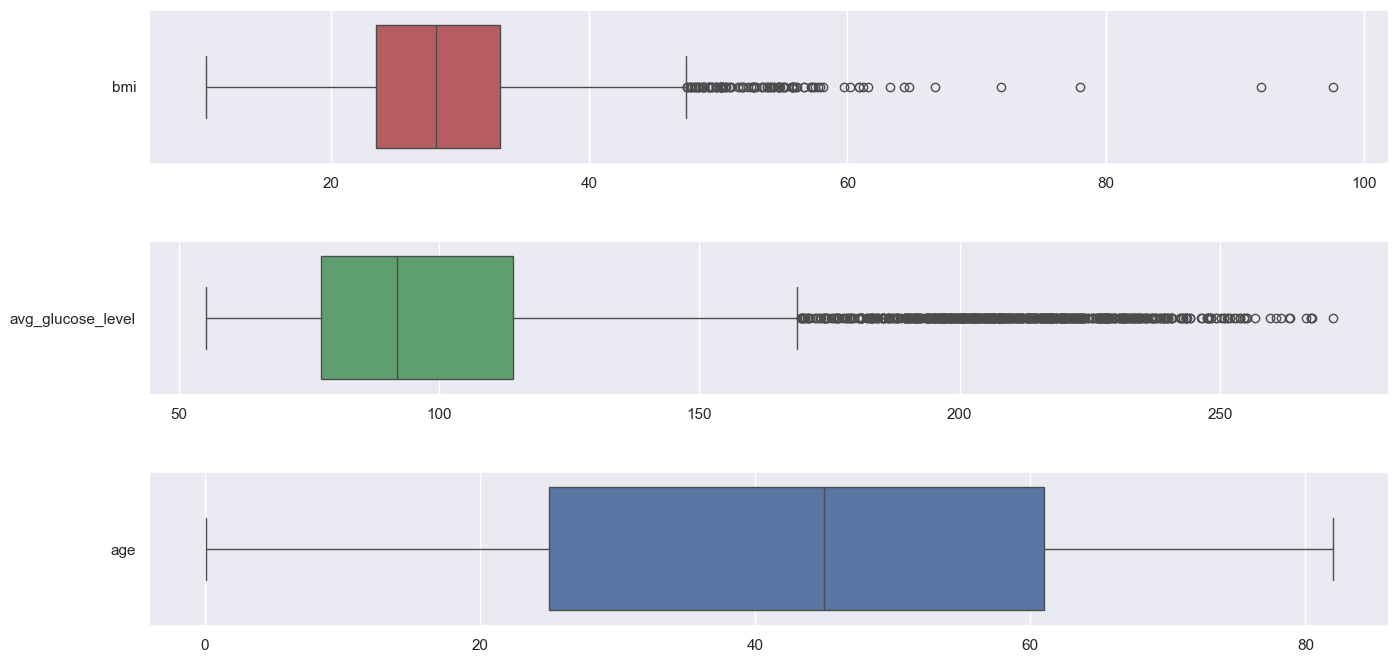

In [40]:
f, axes= plt.subplots(3, 1, figsize=(16, 8))

plt.subplots_adjust(hspace=0.5)
sb.boxplot(data=bmi, orient="h", color="r", ax=axes[0])
sb.boxplot(data=glucose, color="g", orient="h", ax=axes[1])
sb.boxplot(data=age_data, orient="h", color="b", ax=axes[2])

In [41]:
''' Might be duplicate of above

f, axes= plt.subplots(3, 1, figsize=(16, 8))
sb.boxplot(data=bmi_data, orient="h", color="r", ax=axes[0])
sb.boxplot(data=glucose_data, color="g", orient="h", ax=axes[1])
sb.boxplot(data=age_data, orient="h", color="b", ax=axes[2])

'''

' Might be duplicate of above\n\nf, axes= plt.subplots(3, 1, figsize=(16, 8))\nsb.boxplot(data=bmi_data, orient="h", color="r", ax=axes[0])\nsb.boxplot(data=glucose_data, color="g", orient="h", ax=axes[1])\nsb.boxplot(data=age_data, orient="h", color="b", ax=axes[2])\n\n'

## % of responses with stroke

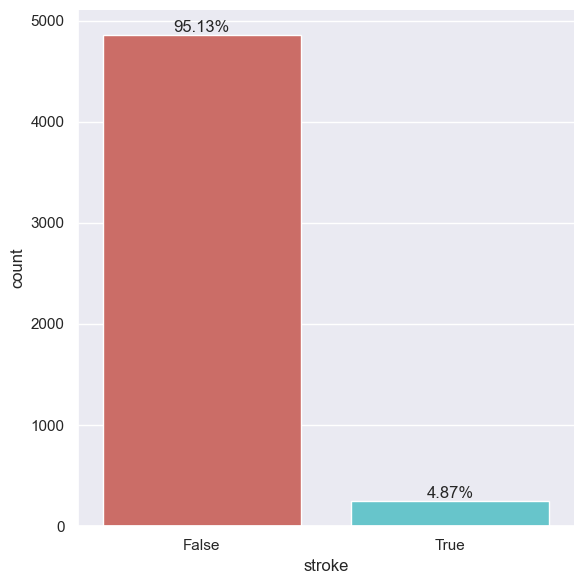

In [42]:
f = sb.catplot(x = "stroke", data = data, kind = "count", height=6, palette="hls", legend=False, hue = "stroke")

ax = f.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()/5110) * 100:.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Exploratory Data Analysis

## Numerical Data

In [43]:
numdata = pd.DataFrame(data[["avg_glucose_level", "bmi", "age", "stroke"]])

numdata = numdata.dropna()

numdata.describe()

,avg_glucose_level,bmi,age
count,4261.000000,4261.000000,4261.000000
mean,91.533922,27.811992,40.602553
std,22.743120,6.721473,22.449546
min,55.120000,10.300000,0.080000
25%,75.060000,23.000000,22.000000
50%,88.060000,27.400000,41.000000
75%,104.070000,32.100000,58.000000
max,168.680000,47.500000,82.000000


<Axes: >

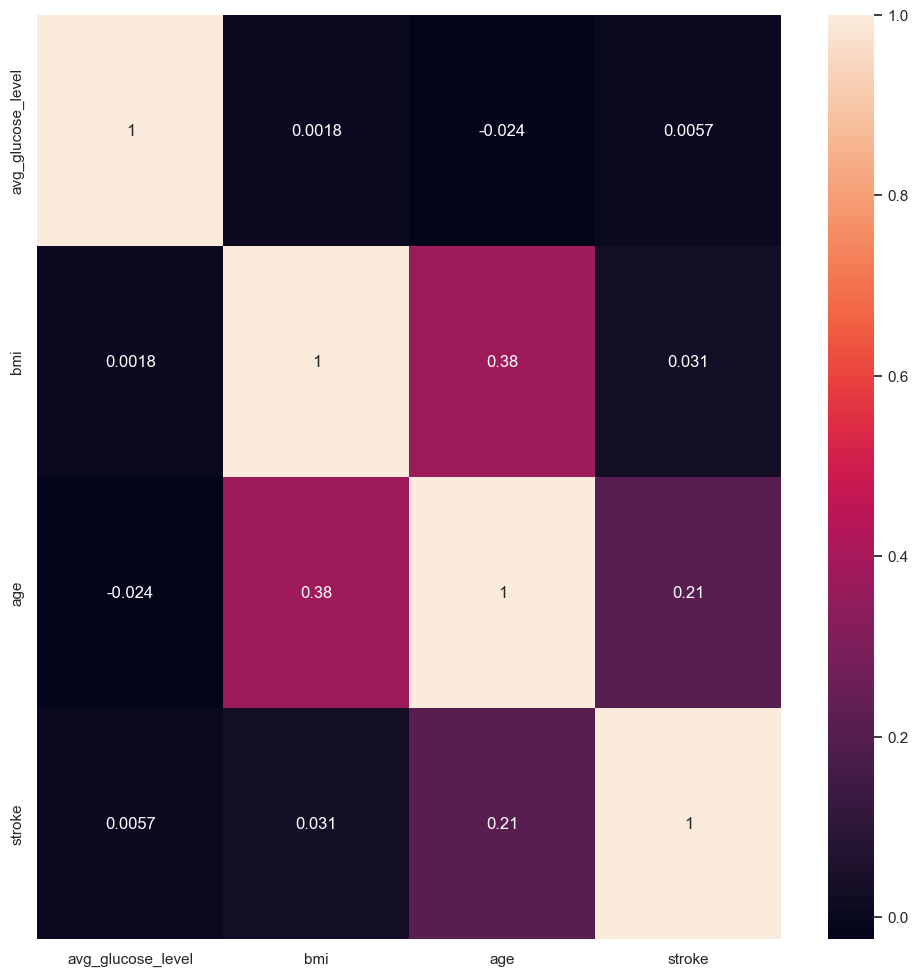

In [44]:
f = plt.figure(figsize=(12,12))
sb.heatmap(numdata.corr(), annot=True)

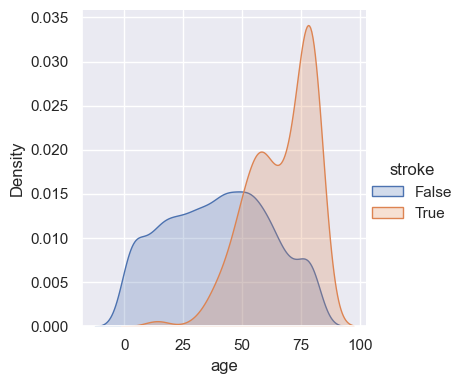

In [45]:
sb.FacetGrid(numdata, hue = "stroke", height = 4,).map(sb.kdeplot, "age", fill = True).add_legend();

## Categorical data

In [54]:
cat = data.select_dtypes(include=['object'])
stroke_only = data["stroke"]

cat['gender'] = gender_data
cat['ever_married'] = ever_data
cat['work_type'] = work_data
cat['Residence_type'] = residence_data
cat['smoking_status'] = clean_smoking_data
cat['hypertension'] = data['hypertension']
cat['heart_disease'] = data['heart_disease'] 
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          5109 non-null   float64
 1   ever_married    5110 non-null   int32  
 2   work_type       5110 non-null   int32  
 3   Residence_type  5110 non-null   int32  
 4   smoking_status  3566 non-null   float64
 5   smoking         3566 non-null   object 
 6   hypertension    5110 non-null   bool   
 7   heart_disease   5110 non-null   bool   
dtypes: bool(2), float64(2), int32(3), object(1)
memory usage: 189.8+ KB


<Axes: >

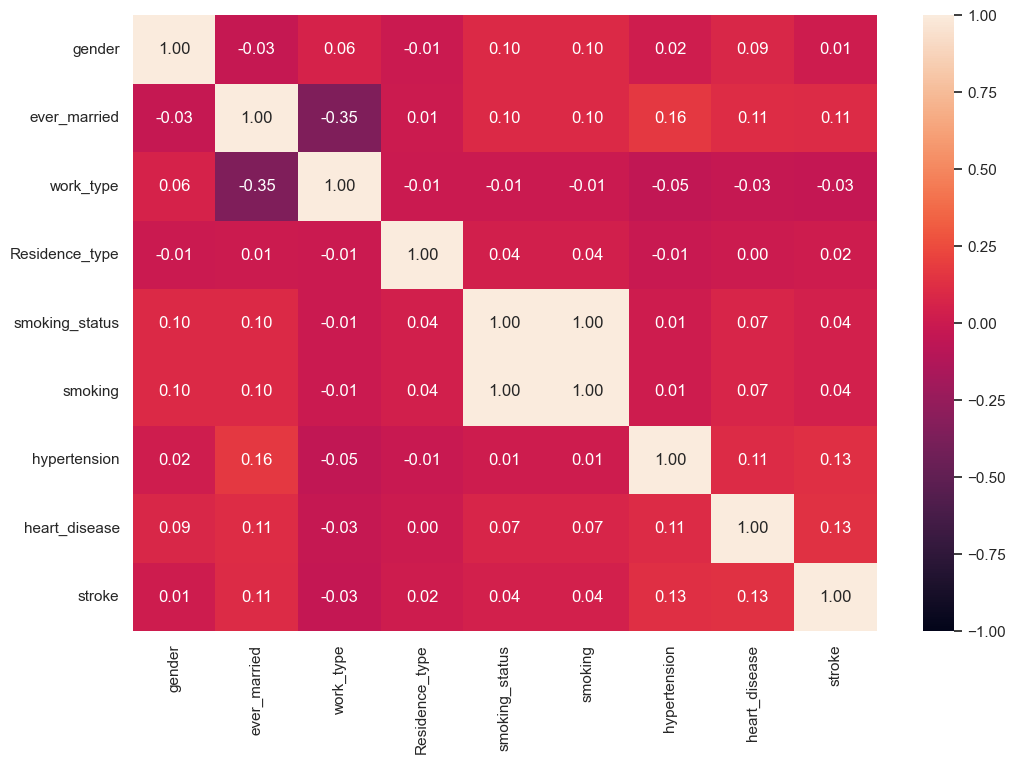

In [55]:
X= stroke_only
y= cat
trainDF = pd.concat([y, X], axis = 1).reindex(y.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [56]:
cat['stroke'] = data['stroke']

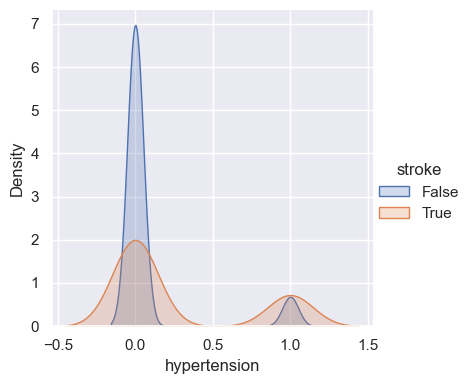

In [57]:
sb.FacetGrid(cat, hue = "stroke", height = 4,).map(sb.kdeplot, "hypertension", fill = True).add_legend();

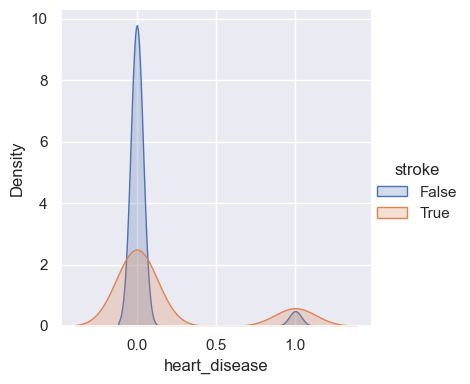

In [58]:
sb.FacetGrid(cat, hue = "stroke", height = 4,).map(sb.kdeplot, "heart_disease", fill = True).add_legend();

# Machine Learning

## Machine Learning Data Prep

In [63]:
def preprocess_sample_data(sample_data, dropna = False):
    # Define bins and labels for BMI and age categorization

    # https://www.myheart.org.sg/tools-resources/bmi-calculator/
    # https://www.singstat.gov.sg/-/media/files/standards_and_classifications/nsa.ashx

    bmi_bins = [0, 18.5, 22.9, 29.9, 1000]
    bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    age_bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 1000]
    age_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
                  '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
    glucose_bins = [0, 90, 160, 230, 500]
    glucose_labels = ['Low', 'Normal', 'High', 'Very High']
    
    
    # Categorize BMI and age
    sample_data['bmi_categorical'] = pd.cut(sample_data['bmi'], bins=bmi_bins, labels=bmi_labels)
    sample_data['age_categorical'] = pd.cut(sample_data['age'], bins=age_bins, labels=age_labels)
    sample_data['glucose_categorical'] = pd.cut(sample_data['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)
    
    # Clearing misleading column value
    sample_data["smoking_status"] = sample_data["smoking_status"].replace(['Unknown'], None)
    
    # One-hot encode nominal features
    nominal_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    sample_data = pd.get_dummies(sample_data, columns=nominal_features)
    
    # Drop unnecessary columns
    sample_data = sample_data.drop(['id'], axis=1)

    
    # Encode ordinal features
    ordinal_features = ['age_categorical', 'bmi_categorical', 'glucose_categorical', 'hypertension', 'heart_disease']
    label_encoder = LabelEncoder()
    for col in ordinal_features:
        sample_data[col] = label_encoder.fit_transform(sample_data[col])
    
    # Normalize numerical features
    numerical_features = ['age', 'bmi', 'avg_glucose_level', 'smoking']
    scaler = StandardScaler()
    sample_data[numerical_features] = scaler.fit_transform(sample_data[numerical_features])

    if dropna:
        sample_data = sample_data.dropna()
    
    return sample_data
    

# Assuming 'sample_data' is your sample_dataframe
processed_sample_data = preprocess_sample_data(data)
X = processed_sample_data.drop(['stroke'], axis=1)
y = processed_sample_data['stroke']

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking,bmi_categorical,age_categorical,glucose_categorical,gender_Female,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.051434,0,1,NaN,1.211369,1.063121,1,13,3,False,...,False,False,True,False,False,False,True,True,False,False
1,0.786070,0,0,NaN,NaN,-0.940626,4,12,3,True,...,False,False,False,True,False,True,False,False,True,False
2,1.626390,0,1,0.639996,0.612001,-0.940626,1,16,2,False,...,False,False,True,False,False,True,False,False,True,False
3,0.255342,0,0,NaN,0.889757,1.063121,1,8,3,True,...,False,False,True,False,False,False,True,False,False,True
4,1.582163,1,0,NaN,-0.630592,-0.940626,2,15,3,True,...,False,False,False,True,False,True,False,False,True,False


In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               4483 non-null   float64
 4   bmi                             4799 non-null   float64
 5   smoking                         3566 non-null   float64
 6   bmi_categorical                 5110 non-null   int32  
 7   age_categorical                 5110 non-null   int32  
 8   glucose_categorical             5110 non-null   int32  
 9   gender_Female                   5110 non-null   bool   
 10  gender_Male                     5110 non-null   bool   
 11  gender_Other                    5110 non-null   bool   
 12  ever_married_No                 51

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2021) # 70% training and 30% test

## Random Forest Classifier

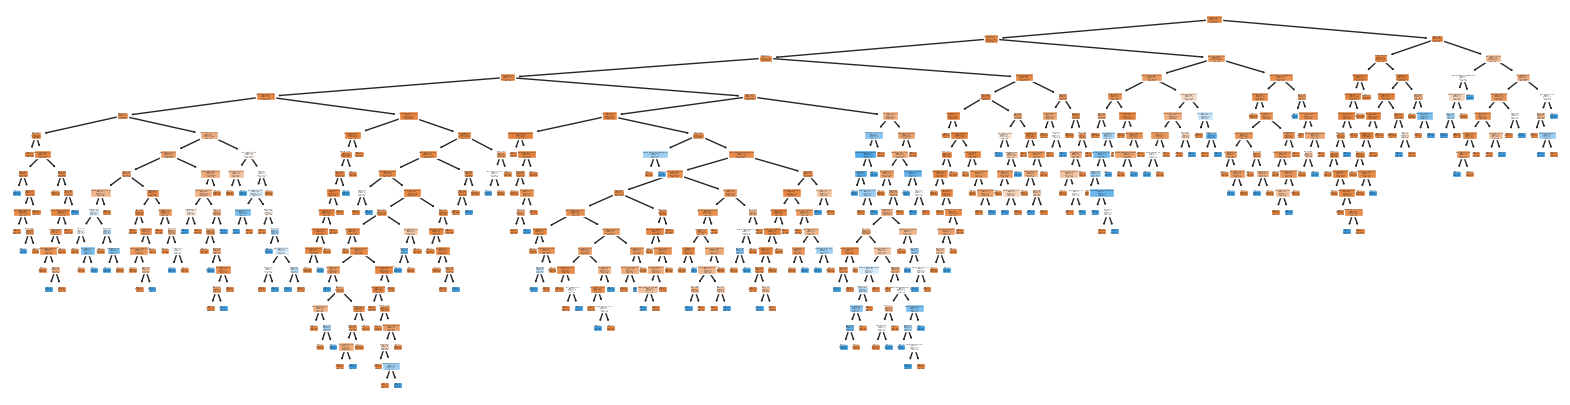

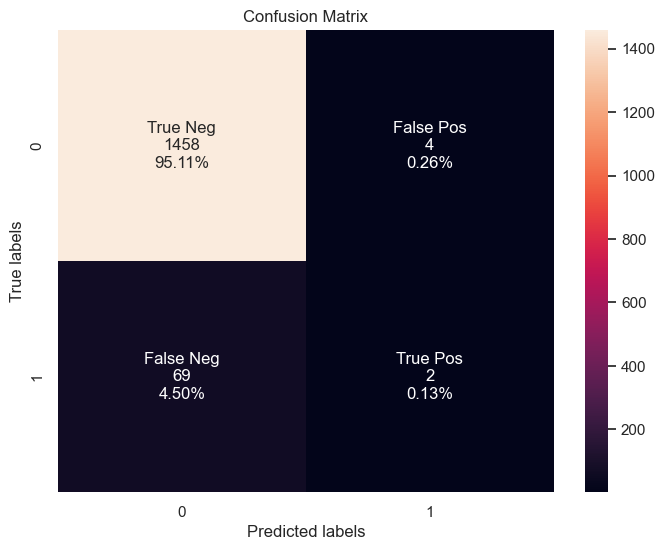

Accuracy: 0.9523809523809523
Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.98      1462
        True       0.33      0.03      0.05        71

    accuracy                           0.95      1533
   macro avg       0.64      0.51      0.51      1533
weighted avg       0.93      0.95      0.93      1533



In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

def random_forest_prediction(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None, random_state=None):
    
    # Initialize Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    
    # Plot a tree from the forest (first tree in the forest)
    plt.figure(figsize=(20,5))
    plot_tree(model.estimators_[0], feature_names=X_train.columns, filled=True, class_names=True)

    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))


    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sb.heatmap(cf_matrix, annot=labels, fmt="")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()
    
    
    return y_pred, accuracy, report

# Example usage:
y_pred, accuracy, report = random_forest_prediction(X_train, X_test, y_train, y_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

## Random Forest Classifier with Grid Search Cross Validation

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


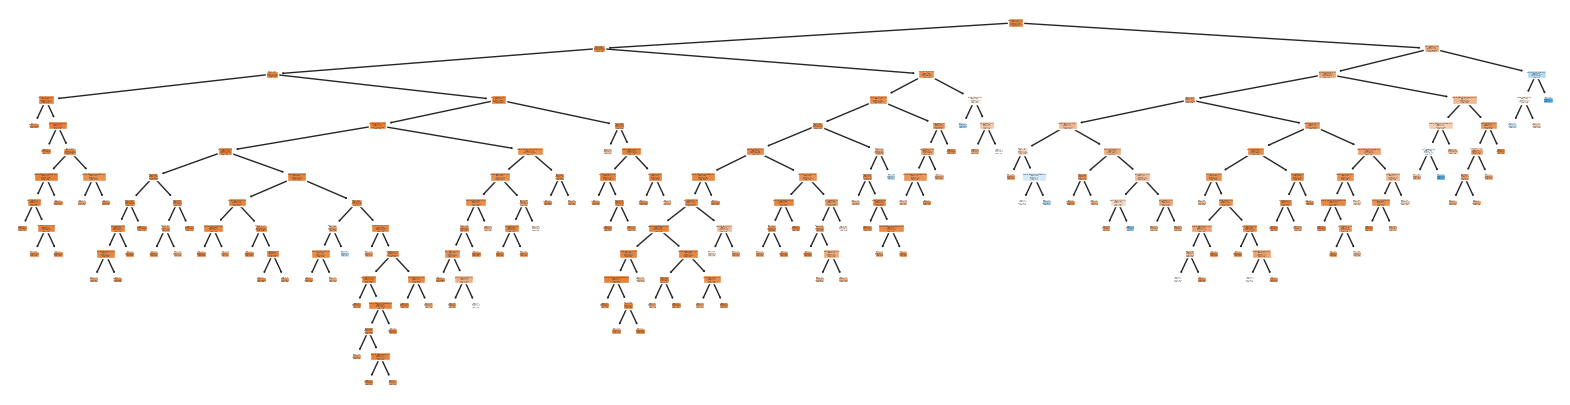

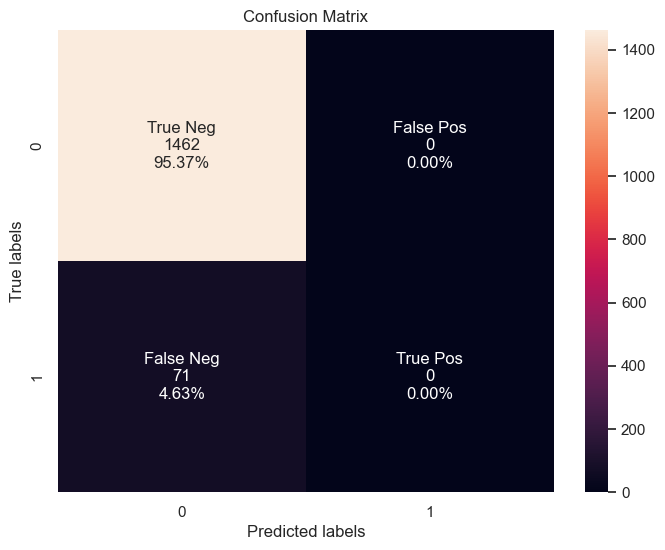

Accuracy: 0.9536855838225701
Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.98      1462
        True       0.00      0.00      0.00        71

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.91      0.95      0.93      1533



In [67]:
from sklearn.model_selection import GridSearchCV

def random_forest_prediction_with_hyperparameter_tuning(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None, random_state=None):
    
    # Define the grid of hyperparameters to search
    param_grid = {
        'n_estimators': [50,100,200],  # Number of trees in the forest
        'max_depth': [None, 10, 15],  # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
        # 'max_features': None  # Number of features to consider when looking for the best split
    }

    
    # Initialize Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    # Get the best model
    best_rf_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_rf_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    
    # Plot a tree from the forest (first tree in the forest)
    plt.figure(figsize=(20,5))
    plot_tree(best_rf_model.estimators_[0], feature_names=X_train.columns, filled=True, class_names=True)

    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))


    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sb.heatmap(cf_matrix, annot=labels, fmt="")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()
    
    
    return y_pred, accuracy, report

# Example usage:
y_pred, accuracy, report = random_forest_prediction_with_hyperparameter_tuning(X_train, X_test, y_train, y_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

## Over sampling SMOTE

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
# drop NA for over sampling
processed_sample_data = preprocess_sample_data(data, True)
X = processed_sample_data.drop(['stroke'], axis=1)
y = processed_sample_data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10) # 70% training and 30% test

In [74]:
smote = SMOTE(sampling_strategy = 0.2)

# Fit and apply the SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.ravel())
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test.ravel())

## Over Sampling Random Forest Classifier

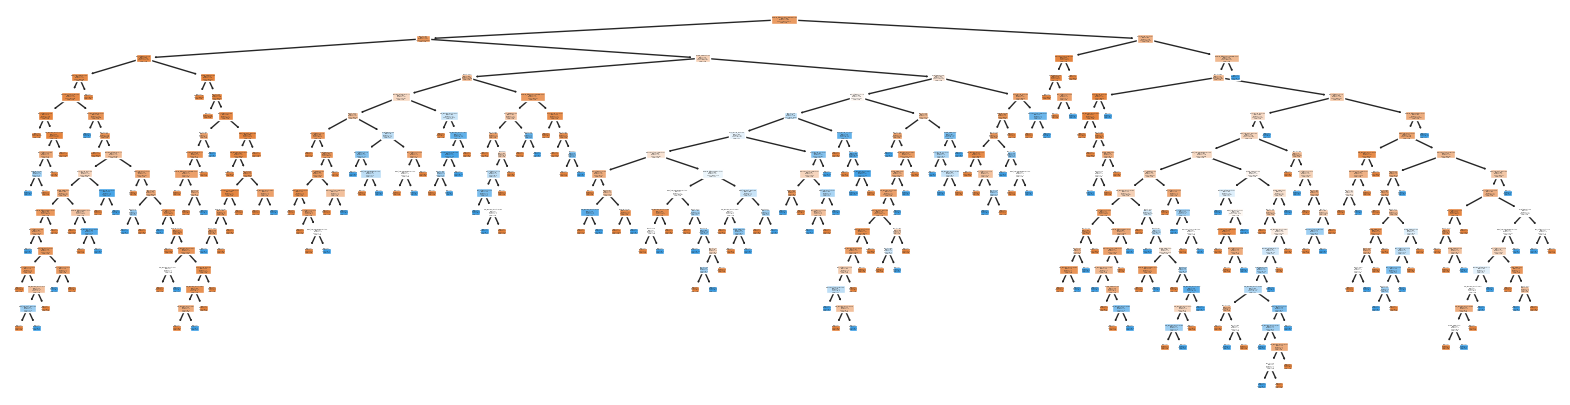

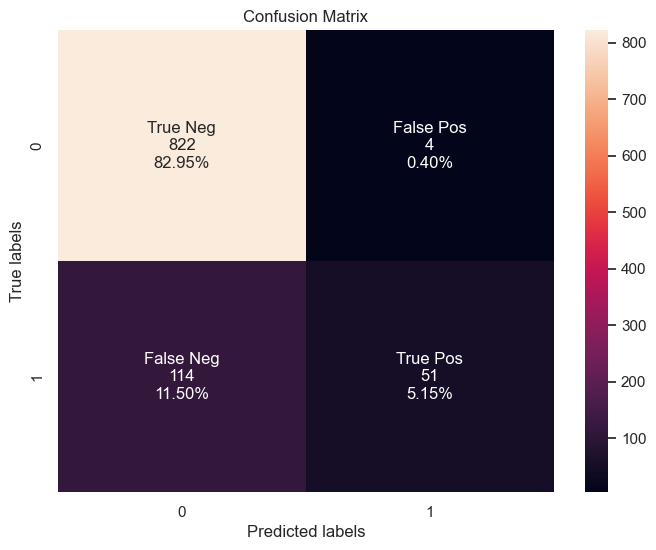

Accuracy: 0.8809283551967709
Classification Report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.93       826
        True       0.93      0.31      0.46       165

    accuracy                           0.88       991
   macro avg       0.90      0.65      0.70       991
weighted avg       0.89      0.88      0.85       991



In [75]:
# Example usage:
y_pred, accuracy, report = random_forest_prediction(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

## Over Sampling Random Forest Classifier with Grid Search Cross Validation

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


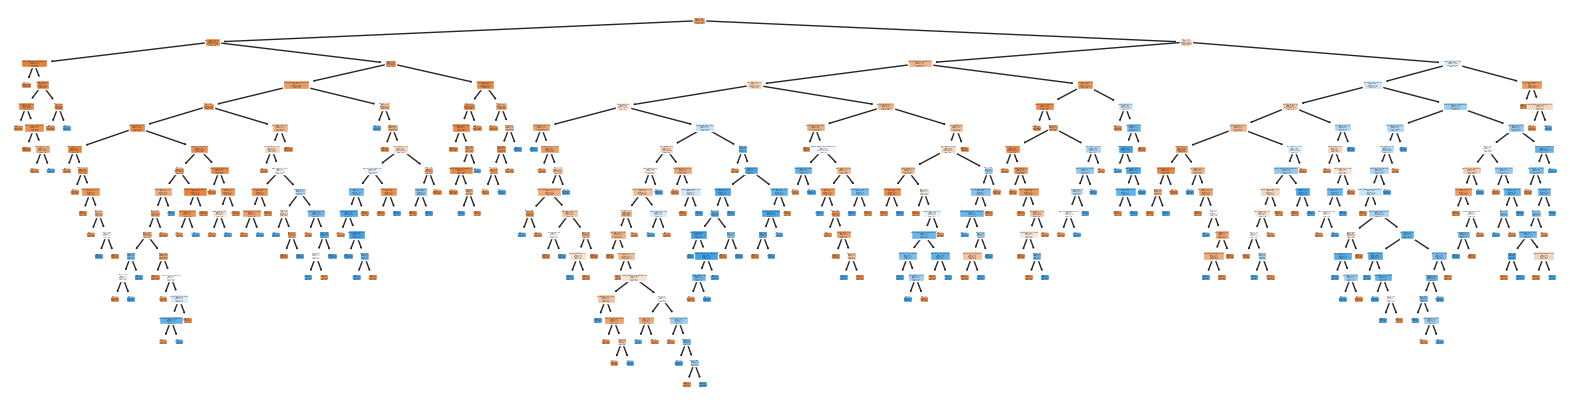

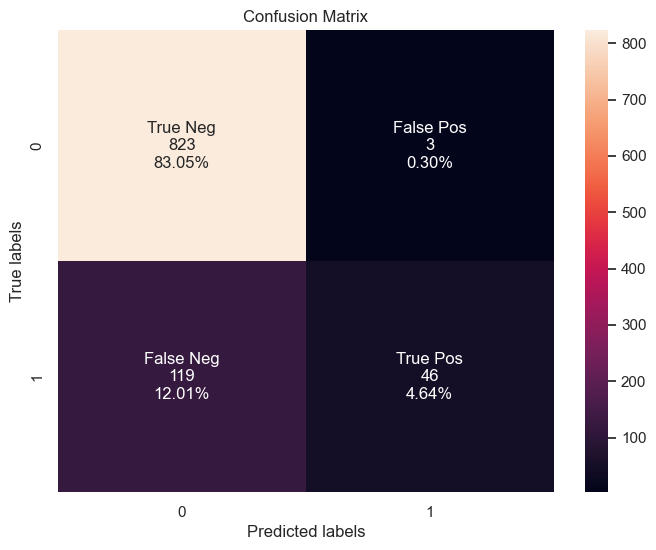

Accuracy: 0.8768920282542886
Classification Report:
              precision    recall  f1-score   support

       False       0.87      1.00      0.93       826
        True       0.94      0.28      0.43       165

    accuracy                           0.88       991
   macro avg       0.91      0.64      0.68       991
weighted avg       0.88      0.88      0.85       991



In [76]:
# Example usage:
y_pred, accuracy, report = random_forest_prediction_with_hyperparameter_tuning(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)